In [36]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

# Handover event function

In [3]:
def mi_event_parsing(miinfofile):
    def nr_pci_track():
        if miinfofile.loc[i, "PCI"] == 65535: ## 65535 is for samgsung phone.
            nr_pci = '-'
        else:
            nr_pci = miinfofile.loc[i, "PCI"]
        return nr_pci

    nr_pci = None ## Initial Unknown
     
    lte_4G_handover_list = []   #4G 狀態下LTE eNB 的 handover
    
    nr_setup_list = []          #gNB cell addition
    nr_handover_list = []       #gNB cell changes (eNB stays the same)
    nr_removal_list = []        #gNB cell removal
        
    lte_5G_handover_list = []   #(eNB1, gNB1) -> (eNB2, gNB1) #gNB stays the same
    nr_lte_handover_list = []   #both NR cell and LTE cell have handover
    
    eNB_to_MN_list = []
    MN_to_eNB_list = []
    
    scg_failure_list = []       #gNB handover failure
    reestablish_list_type2 = [] #eNB handover failure
    reestablish_list_type3 = []
    
    SCell_rel = []
    SCell_add = []
    # SCell_add_rel = []

    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    
    lte_failure = 0
    lte_failure_start_index = None
    
    handover_num = 0
    
    for i in range(len(miinfofile)):
        if miinfofile.loc[i, "type_id"] == "5G_NR_RRC_OTA_Packet":
            nr_pci = nr_pci_track()
            continue
            
        if miinfofile.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
                
        if miinfofile.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
                
        if miinfofile.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
           
        if (nr_handover or lte_handover or nr_release) and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num +=1
        
        
        #handover 種類分類
        #------------------------------------------------------------------------------
        if lte_handover and not nr_handover and not nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just lte cell handover event
            lte_handover = 0
            lte_4G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            

        if lte_handover and not nr_handover and nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:    # LTE Ho and nr release 
            lte_handover = 0
            nr_release = 0
            MN_to_eNB_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
        
        if nr_handover and not lte_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just nr cell handover event
            nr_handover = 0
            if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                nr_setup_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])       
            else:
                nr_handover_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            #additional judgement:
            #----------------------------
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #    print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != miinfofile.loc[nr_handover_start_index, "nr_pci"]): 
            #    print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, miinfofile.loc[nr_handover_start_index, "nr_pci"], nr_pci)
                
        if lte_handover and nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:      # both nr cell and lte cell handover event
            lte_handover = 0
            nr_handover = 0
            if nr_pci == miinfofile.loc[lte_handover_start_index, "nr_physCellId"]: 
                lte_5G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            else:
                ##############
                if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                    eNB_to_MN_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])       
                else:
                    nr_lte_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            
        if not lte_handover and  nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_release=0
            nr_removal_list.append([miinfofile.loc[nr_release_start_index, "time"], miinfofile.loc[i, "time"]])
            
        if miinfofile.loc[i, "scgFailureInformationNR-r15"]:
            scg_failure_list.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]]) 
            
        if miinfofile.loc[i, "rrcConnectionReestablishmentRequest"]:
            if lte_failure == 0:
                lte_failure = 1
                lte_failure_start_index = i
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishment"]:
            lte_failure = 0
            reestablish_list_type2.append([miinfofile.loc[lte_failure_start_index, "time"], miinfofile.loc[lte_failure_start_index, "time"]])
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishmentReject"]:
            lte_failure = 0
            reestablish_list_type3.append([miinfofile.loc[lte_failure_start_index, "time"], miinfofile.loc[lte_failure_start_index, "time"]])
        
        if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0' and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0):
            SCell_rel.append([miinfofile.loc[i, "time"]])
        
        if miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
            SCell_add.append([miinfofile.loc[i, "time"]])

        # if miinfofile.loc[i, "sCellToReleaseList-r10"] and miinfofile.loc[i, "SCellToAddMod-r10"]:
        #     SCell_add_rel.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]])


    return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, eNB_to_MN_list, MN_to_eNB_list, scg_failure_list, reestablish_list_type2, reestablish_list_type3, SCell_rel, SCell_add], handover_num

def collect_ho_event(mi_rrc_df):
    l, _ = mi_event_parsing(mi_rrc_df)
    for i in range(len(l)):
        l[i] = [j[0] for j in l[i]]
    d = {'lte': l[0], 'nr_setup': l[1], 'gNB_ho': l[2], 'nr_rel': l[3], "MN_changed": l[4],"MN_SN_changed": l[5],
     "eNB to MN changed": l[6], "MN to eNB changed": l[7], "gNB fail": l[8], "type2 fail": l[9], "type3 fail": l[10], 'SCell_rel': l[11], 'SCell_add': l[12]}
    return d

In [56]:
def parse_mi_ho(df):
    def NR_OTA():
        if df["type_id"].iloc[i] == "5G_NR_RRC_OTA_Packet":
            return True
        else:
            return False

    def find_1st_after(target, look_after=1):
        for j in range(i, len(df)):
            t_ = df["time"].iloc[j]
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0']:
                return t_, j

    def find_1st_before(target, look_before=1):
        for j in range(i, -1, -1):
            t_ = df["time"].iloc[j]
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0']:
                return t_, j

    HO = namedtuple('HO','start, end, others', defaults=(None,None))

    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR
        # 'HOF': [], # Didn't defined yet.
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        }

    for i in range(len(df)):
        if NR_OTA():
            continue

        t = df["time"].iloc[i]
        
        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))

        if df["rrcConnectionRequest"].iloc[i] == 1:
            a, _ = find_1st_after('rrcConnectionReconfigurationComplete',look_after=2) or (None, None)
            b, _ = find_1st_after('securityModeComplete',look_after=2) or (None, None)
            if a is None and b is None:
                end = None
            else:
                end = a if a > b else b 
            D['Conn_Req'].append(HO(start=t,end=end))
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], df['lte_targetPhysCellId'].iloc[i]
            serv_freq, target_freq = df["Freq"].iloc[i], df['dl-CarrierFreq'].iloc[i]
            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others=f'Set up {n} SCell.'
            else:
                others=None
            
            if serv_freq != target_freq:
                others += " Inter freq. HO"
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SN_setup'].append(HO(start=t, end=end, others=others))
                    # print(1, t, f"Serving Cell: {serv_cell}->{target_cell}")  
                else:    
                    D['MN_HO'].append(HO(start=t, end=end, others=others))
            else:
                if serv_cell == target_cell and serv_freq == target_freq:
                    a, b = find_1st_before("scgFailureInformationNR-r15")
                    if a is not None:
                        others += "Caused by scg-failure."
                    D['SN_Rel'].append(HO(start=t, end=end, others=others))
                else:
                    D['LTE_HO'].append(HO(start=t, end=end, others=others))

        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReconfigurationComplete')
            D['SN_HO'].append(HO(start=t,end=end))

        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after('rrcConnectionReestablishmentReject', look_after=1)
            others = df["reestablishmentCause"].iloc[i]
            if end is not None: 
                # Type II
                D['RLF_II'].append(HO(start=t,end=end,others=others))
            else: 
                # Type III
                D['RLF_III'].append(HO(start=t,end=b,others=others)) # End for Type III?
            
        if df["scgFailureInformationNR-r15"].iloc[i] == 1:
            others = df["failureType-r15"].iloc[i]
            D['SCG_RLF'].append(HO(start=t,others=others))
    
    return D

# Read file

In [39]:
## Mobileinsight csv file~
file = '/home/wmnlab/diag_log_qc01_2023-02-27_17-43-36.mi2log_rrc.csv'
mi_rrc_df = pd.read_csv(file)
mi_rrc_df["time"] = pd.to_datetime(mi_rrc_df["time"]) + dt.timedelta(hours=8)

file2 = '/home/wmnlab/diag_log_qc01_2023-02-27_17-43-36.mi2log_ml1_new.csv'
mi_ml1_df = pd.read_csv(file2)
mi_ml1_df["time"] = pd.to_datetime(mi_ml1_df["time"]) + dt.timedelta(hours=8)

file3 = '/home/wmnlab/diag_log_qc01_2023-02-27_17-43-36.mi2log_nr_ml1_new.csv'
mi_nr_ml1_df = pd.read_csv(file3)
mi_nr_ml1_df["time"] = pd.to_datetime(mi_nr_ml1_df["time"]) + dt.timedelta(hours=8)

# LTE Signal Strength

In [86]:
class data_point:
    def __init__(self, pd_data): ## Input pd_df.iloc[index]
        self.time = pd_data['time']
        self.pci = pd_data['PCI']
        self.servingcell = pd_data['Serving Cell Index']
        self.earfcn = pd_data['EARFCN']
        self.RSRPQ = float(pd_data['RSRP(dBm)']), float(pd_data['RSRQ(dB)'])
        self.neighbor = self.get_nei_pci_signal_strength(pd_data)

    def get_nei_pci_signal_strength(self, pd_data):
        nei_cells = {}
        for i in range(9, len(pd_data), 3):
            if np.isnan(pd_data[i]):
                break
            else:
                nei_cells[int(pd_data[i])] = (float(pd_data[i+1]), float(pd_data[i+2]))                
        return nei_cells

class Signal_Strength_map:
    def __init__(self, mi_ml1_df, mi_rrc_df=None):
        self.L = self.data_list(mi_ml1_df)
        if mi_rrc_df is not None:
            self.ho_event = self.collect_ho_event(mi_rrc_df)
    def data_list(self, mi_ml1_df):
        L = []
        for i in range(len(mi_ml1_df)):
            L.append(data_point(mi_ml1_df.iloc[i]))
        return L

    def draw_pci_rsrp(self, pci_list, x_lim=None, y_lim=None, show_earfcn=False, show_ho=[]): ## Format of l: [('pci1', 'earfcn1'), (pci2, earfcn2), (pci3, earfcn3),...] 
        pci_wanted = [i[0] for i in pci_list]
        earfcn_wanted = [i[1] for i in pci_list]

        if len(pci_list) == 0:
            print("Empty pci list.")
            return
        else:
            x_lists = [] ## Time x = [x1, x2, x3, ...]
            rsrp_lists = [] ## rsrp = [rsrp1, rsrp2, rsrp3, ...]
            for i in range(len(pci_list)):
                x_lists.append([])
                rsrp_lists.append([])

            for i in range(len(self.L)):
                data = self.L[i]
                neighbor_list = list(data.neighbor.keys())
                
                for j in range(len(pci_list)):
                    if data.pci == pci_wanted[j] and data.earfcn == earfcn_wanted[j]:
                        x_lists[j].append(data.time)
                        rsrp_lists[j].append(data.RSRPQ[0])

                    for nei_pci in neighbor_list:
                        if nei_pci == pci_wanted[j] and data.earfcn == earfcn_wanted[j]:
                            x_lists[j].append(data.time)
                            rsrp_lists[j].append(data.neighbor[nei_pci][0])
            
        fig = plt.figure(figsize=(15, 3))
        for i in range(len(x_lists)):
            diff = [(x_lists[i][j+1] - x_lists[i][j]).total_seconds() for j in range(len(x_lists[i])) if j != len(x_lists[i]) -1 ]
            test = 3

            l = []
            for j in range(len(diff)):
                if diff[j] > test: ## If diff > test, no connected
                    l.append(j)
            
            count = 0
            for j in l:
                x_lists[i].insert(j+count+1, x_lists[i][j+count] + dt.timedelta(seconds=test))
                rsrp_lists[i].insert(j+count+1, np.nan)
                count += 1
            
            plt.plot(x_lists[i],rsrp_lists[i])

        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        x_min, x_max = axes.get_xlim()

        colors = ['red', 'green', 'pink', 'cyan', 'lightskyblue']
        if len(show_ho) != 0:
            d = self.ho_event
            i = 0
            for ho in show_ho:
                a = [ i for i in self.ho_event[ho]]
                plt.vlines(a,ymin=y_min, ymax=y_max,label=ho, color=colors[i])
                i += 1

        if show_earfcn:
            legend = [p+' ('+e+')' for p,e in zip(pci_wanted, earfcn_wanted)] 
            plt.legend(legend+show_ho)
        else:
            plt.legend(pci_wanted+show_ho)
            
        if x_lim is not None:
            plt.xlim(x_lim)
        else:
            plt.xlim(x_min, x_max)
        
        if y_lim is not None:
            plt.ylim(y_lim)
        # plt.gcf().autofmt_xdate()
        plt.ylabel("RSRP")
        plt.xlabel("Time")
        plt.show()

    def collect_ho_event(self, mi_rrc_df):
        d = parse_mi_ho(mi_rrc_df)
        for key in d:
            d[key] = [x.start for x in d[key]]
        return d
    
    def draw_ho_event(self, ho_type, x_lim=None):
        fig = plt.figure(figsize=(15, 3))
        colors = ['red', 'green', 'pink', 'cyan', 'lightskyblue']
        i = 0
        for type in ho_type:
            if type in list(self.ho_event.keys()):
                a = self.ho_event[type]
                plt.vlines(a,ymin=0, ymax=1,label=type, color=colors[i])
                i += 1
        
        if x_lim is not None:
            plt.xlim(x_lim)
            
        plt.legend()
        plt.show()

In [87]:
x = Signal_Strength_map(mi_ml1_df, mi_rrc_df)

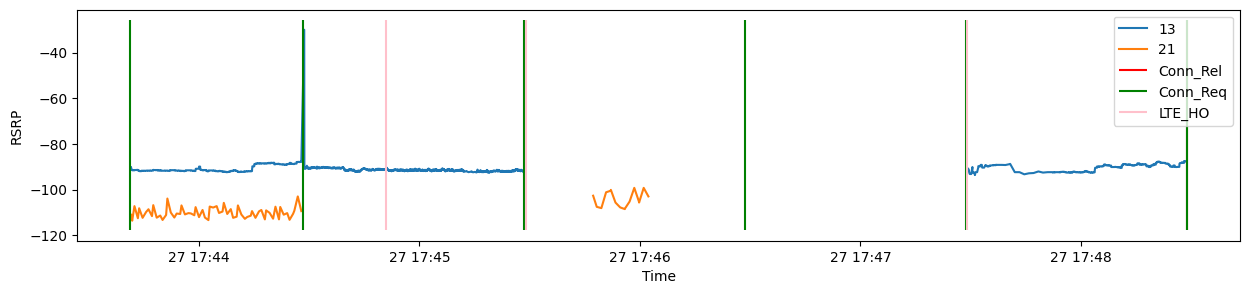

In [88]:
pci_list = [(13, 1750), (21, 3050)]
show_ho = ['Conn_Rel', 'Conn_Req', "LTE_HO"]
x.draw_pci_rsrp(pci_list, show_ho=show_ho)

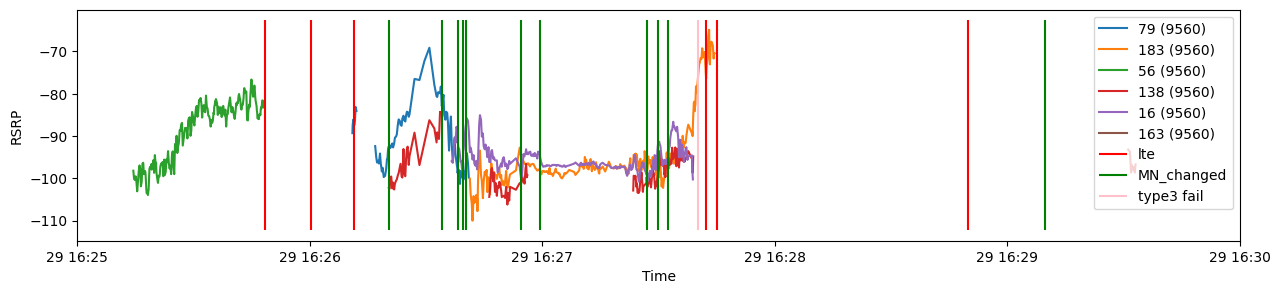

In [13]:
pci_list = [('79', '9560'), ('183','9560'), ('56', '9560'), ('138', '9560'), ('16', '9560'), ('163','9560')]
time_range = [dt.datetime(2022, 9, 29, 16, 25, 0), dt.datetime(2022, 9, 29, 16, 30, 0)]
# time_range = None
# rsrp_range = [-120, -80]
rsrp_range = None
show_ho = ['lte', 'MN_changed', "type3 fail"]
# show_ho = ['SCell_add_rel']

x.draw_pci_rsrp(pci_list, show_earfcn=True, x_lim=time_range, y_lim=rsrp_range, show_ho=show_ho)

# NR Signal Stremgth

In [104]:
class nr_data_point:
    def __init__(self, pd_data): ## Input pd_df.iloc[index]
        self.time = pd_data['time']
        # self.servingcell_index = pd_data['Serving Cell Index']
        # self.servingcell_index = pd_data['Serving Cell PCI']
        # self.earfcn = pd_data['Raster ARFCN']
        self.neighbor = self.get_nei_pci_signal_strength(pd_data)

    def get_nei_pci_signal_strength(self, pd_data):
        nei_cells = {}
        for i in range(6, len(pd_data), 3):
            if np.isnan(pd_data[i]):
                break
            else:
                if i == 6:
                    nei_cells[pd_data[i]] = (float(pd_data[i+1]), float(pd_data[i+2]))
                else:
                    nei_cells[int(pd_data[i])] = (float(pd_data[i+1]), float(pd_data[i+2]))                
        return nei_cells

class Signal_Strength_map:
    def __init__(self, mi_nr_ml1_df, mi_rrc_df=None):
        self.L = self.data_list(mi_nr_ml1_df)
        if mi_rrc_df is not None:
            self.ho_event = self.collect_ho_event(mi_rrc_df)
    def data_list(self, mi_nr_ml1_df):
        L = []
        for i in range(len(mi_nr_ml1_df)):
            L.append(nr_data_point(mi_nr_ml1_df.iloc[i]))
        return L

    def draw_pci_rsrp(self, pci_list, x_lim=None, y_lim=None, show_ho=[]): ## Format of pci_list: ['pci1', 'pci2', ...] 
        if len(pci_list) == 0:
            print("Empty pci list.")
        else:
            x_lists = [] ## Time x = [x1, x2, x3, ...]
            rsrp_lists = [] ## rsrp = [rsrp1, rsrp2, rsrp3, ...]
            for i in range(len(pci_list)):
                x_lists.append([])
                rsrp_lists.append([])

            for i in range(len(self.L)):
                data = self.L[i]
                neighbor_list = list(data.neighbor.keys())
                
                for j in range(len(pci_list)):
                    for nei_pci in neighbor_list:
                        if nei_pci == pci_list[j]:
                            x_lists[j].append(data.time)
                            rsrp_lists[j].append(data.neighbor[nei_pci][0])
            
        fig = plt.figure(figsize=(15, 3))
        for i in range(len(x_lists)):
            diff = [(x_lists[i][j+1] - x_lists[i][j]).total_seconds() for j in range(len(x_lists[i])) if j != len(x_lists[i]) -1 ]
            test = 3

            l = []
            for j in range(len(diff)):
                if diff[j] > test: ## If diff > test, no connected
                    l.append(j)
            
            count = 0
            for j in l:
                x_lists[i].insert(j+count+1, x_lists[i][j+count] + dt.timedelta(seconds=test))
                rsrp_lists[i].insert(j+count+1, np.nan)
                count += 1
            
            plt.plot(x_lists[i],rsrp_lists[i])

        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        x_min, x_max = axes.get_xlim()

        colors = ['red', 'green', 'pink', 'cyan', 'lightskyblue']
        if len(show_ho) != 0:
            d = self.ho_event
            i = 0
            for ho in show_ho:
                a = [ i for i in self.ho_event[ho]]
                plt.vlines(a,ymin=y_min, ymax=y_max,label=ho, color=colors[i])
                i += 1


        plt.legend(pci_list+show_ho)
            
        if x_lim is not None:
            plt.xlim(x_lim)
        else:
            plt.xlim(x_min, x_max)
        
        if y_lim is not None:
            plt.ylim(y_lim)
        plt.ylabel("RSRP")
        plt.xlabel("Time")
        plt.show()

    def collect_ho_event(self, mi_rrc_df):
        d = parse_mi_ho(mi_rrc_df)
        for key in d:
            d[key] = [x.start for x in d[key]]
        return d
    
    def draw_ho_event(self, ho_type, x_lim=None):
        fig = plt.figure(figsize=(15, 3))
        colors = ['red', 'green', 'orange', 'cyan', 'lightskyblue']
        i = 0
        for type in ho_type:
            if type in list(self.ho_event.keys()):
                a = self.ho_event[type]
                plt.vlines(a,ymin=0, ymax=1,label=type, color=colors[i])
                i += 1
        
        if x_lim is not None:
            plt.xlim(x_lim)
            
        plt.legend()
        plt.show()
    
    

In [105]:
x = Signal_Strength_map(mi_nr_ml1_df, mi_rrc_df)

In [118]:
# x.ho_event

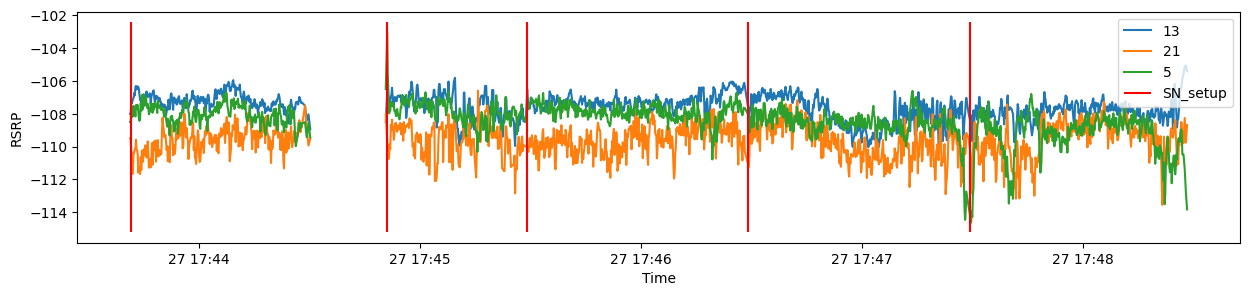

In [117]:
ho_type = ['SN_setup']
time_range = None
pci_list = [13, 21, 5]
x.draw_pci_rsrp(pci_list=pci_list, x_lim=time_range, show_ho=ho_type)